Notebook for training a 3D U-Net for vestibular schwannoma segmentation.

In [ ]:
# This cell is for Colab runs

!pip install tensorflow==2.10.1  # same version of tf used in local testing, Colab default (2.13) gives import errors with segmentation models library

!pip install segmentation_models_3D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf
import pandas as pd
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [3]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_DEPTH = 64
IMG_CHANNELS = 1
SEED = 42
random.seed(SEED)

Connect to Drive if running on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data.

In [4]:
#Colab data paths
# mris_path = "/content/drive/MyDrive/bsc_thesis_data_t1_numpy/mris_dataset.npy"
# masks_path = "/content/drive/MyDrive/bsc_thesis_data_t1_numpy/masks_dataset.npy"

# Paths on local machine
mris_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\mris_dataset.npy"
masks_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\masks_dataset.npy"

mris = np.load(mris_path)
masks = np.load(masks_path)



In [5]:
mris.shape

(242, 64, 64, 64)

In [6]:
masks.shape

(242, 64, 64, 64)

Normalise the data.

In [7]:
# def normalize_3d_image(img):
#     return (img - img.min()) / (img.max() - img.min())


def standardize_3d_image(img):
    """
    Standardize a 3D image using Z-score normalization.

    Parameters:
    - img: 3D numpy array representing the MRI image.

    Returns:
    - standardized_img: 3D numpy array representing the standardized MRI image.
    """
    mean = np.mean(img)
    std = np.std(img)
    standardized_img = (img - mean) / std
    return standardized_img

Normalise the data and print out the min and max pixel intensities before and after.

In [8]:
print(np.min(mris))
print(np.max(mris))

0.0
4093.7407


In [9]:
for i in range(mris.shape[0]):
    mris[i] = standardize_3d_image(mris[i])

In [10]:
print(np.min(mris))
print(np.max(mris))

-0.9647217
11.05375


Function for building the model.

In [11]:
def build():

  model = sm.Unet(
      "resnet34",
      input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, IMG_CHANNELS),
      encoder_weights=None,
      activation="sigmoid",
  )


  dice_loss = sm.losses.DiceLoss()
  bce_loss = sm.losses.BinaryCELoss()
  total_loss = dice_loss + bce_loss


  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
  )
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=total_loss,
      metrics=[sm.metrics.IOUScore()],
  )
  return model

Initialise the k-fold cross validation and lists to store evaluation metrics.

In [12]:
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)

indices = np.arange(len(mris)) # Array for patient indices for retracing patients after cross-validation shuffle. 
train_iou_list = []
val_iou_list = []
dataframes = []

In [13]:
def build_dfs(test_ids, dice_scores):
    data = {
        "Patient Indices": test_ids,
        "Dice": dice_scores
    }
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

Create a function to evaluate the segmentation performance.

In [14]:
def getScore(predictions, test_mask):
    intersection = np.logical_and(test_mask, predictions)
    dice_score = (np.sum(intersection) * 2) / (np.sum(predictions) + np.sum(test_mask))

    return dice_score

Set callbacks for the training.

In [15]:
cb = tf.keras.callbacks.EarlyStopping(
      monitor="val_iou_score", mode="max", patience=10, restore_best_weights=True
  )

Train the model inside the cross-validation loop.

In [16]:
for train_index, test_index in kf.split(mris, masks):
  # Split data
  X_train, X_test = mris[train_index], mris[test_index]
  Y_train, Y_test = masks[train_index], masks[test_index]
  train_ids, test_ids = indices[train_index], indices[test_index]

  print(
      f"Training data\nDimensions: {X_train.shape}\nMax-value: {np.max(X_train)}\nMin-value: {np.min(X_train)}"
  )
  print(
    f"Test data\nDimensions: {X_test.shape}\nMax-value: {np.max(X_test)}\nMin-value: {np.min(X_test)}"
  )
  model = build()
  history = model.fit(
    X_train, Y_train, epochs=100, batch_size=8, validation_split=0.20, callbacks=[cb]
  )

  train_iou_list.append(history.history["iou_score"])
  val_iou_list.append(history.history["val_iou_score"])

  # Loop through each item, predict, and calculate scores

  dice_scores = [] # list for containing an individual test folds dice scores

  for i in range(X_test.shape[0]):
      single_item = np.expand_dims(X_test[i], axis=0)
      pred = model.predict(single_item)
      pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
      Y_test_single = Y_test[i]
      dice_score = getScore(pred_t, Y_test_single)

      dice_scores.append(dice_score)

  dataframes.append(build_dfs(test_ids, dice_scores))


Training data
Dimensions: (193, 64, 64, 64)
Max-value: 11.053750038146973
Min-value: -0.9647216796875
Test data
Dimensions: (49, 64, 64, 64)
Max-value: 10.367440223693848
Min-value: -0.9305791854858398
Epoch 1/100
20/20 [==============================] - 47s 1s/step - loss: 1.3405 - iou_score: 3.6225e-04 - val_loss: 1.2360 - val_iou_score: 3.1723e-10
Epoch 2/100
20/20 [==============================] - 19s 947ms/step - loss: 1.0395 - iou_score: 0.0020 - val_loss: 1.0816 - val_iou_score: 9.1794e-10
Epoch 3/100
20/20 [==============================] - 19s 932ms/step - loss: 0.9957 - iou_score: 0.0135 - val_loss: 1.8470 - val_iou_score: 8.2126e-11
Epoch 4/100
20/20 [==============================] - 19s 943ms/step - loss: 0.9319 - iou_score: 0.0386 - val_loss: 12.0906 - val_iou_score: 4.4943e-04
Epoch 5/100
20/20 [==============================] - 19s 940ms/step - loss: 0.6375 - iou_score: 0.2475 - val_loss: 1.0483 - val_iou_score: 3.4556e-04
Epoch 6/100
20/20 [===========================

Evaluate the model.

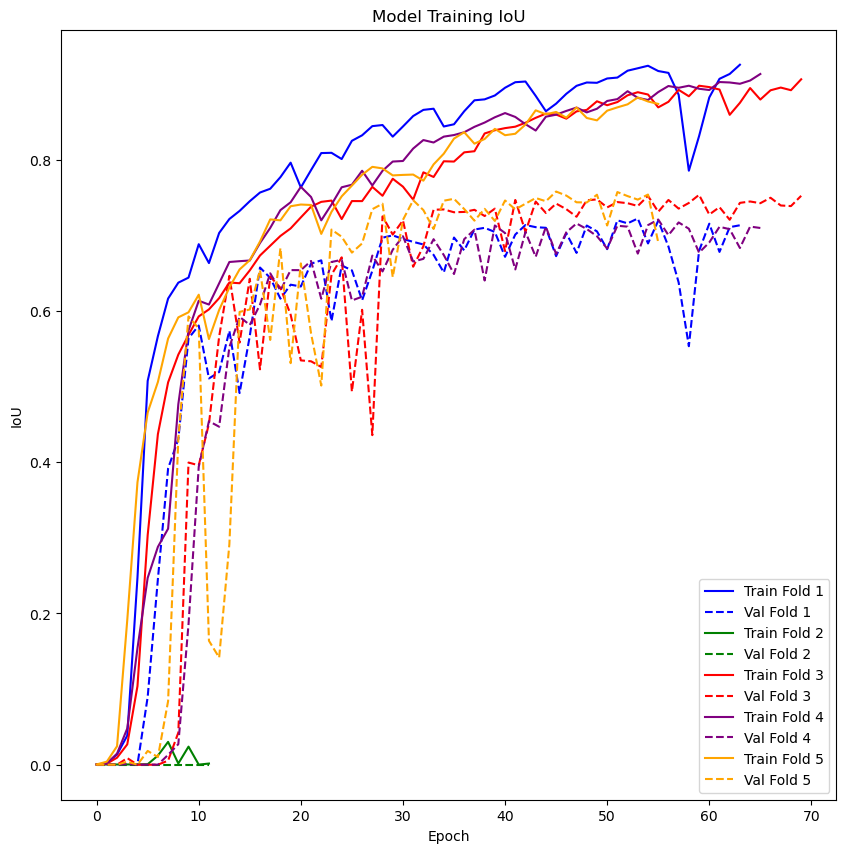

In [17]:
plt.figure(figsize=(10, 10))
colors = ["blue", "green", "red", "purple", "orange"]  # Define colors for the curves
for i, color in enumerate(colors):
    plt.plot(train_iou_list[i], color=color, linestyle="-")
    plt.plot(val_iou_list[i], color=color, linestyle="--")

plt.title("Model Training IoU")
plt.ylabel("IoU")
plt.xlabel("Epoch")
plt.legend(
    [
        "Train Fold 1",
        "Val Fold 1",
        "Train Fold 2",
        "Val Fold 2",
        "Train Fold 3",
        "Val Fold 3",
        "Train Fold 4",
        "Val Fold 4",
        "Train Fold 5",
        "Val Fold 5",
    ],
    loc="lower right",
)

plt.show()



In [19]:

for i, dataframe in enumerate(dataframes): 
    print(dataframe["Dice"].mean())

0.7493675626522397
0.0
0.752635141162001
0.7748567213003605
0.7437728297349816


In [50]:
concatenated_df = pd.concat(dataframes)

# Compute the average of dice scores
avg_dice = concatenated_df['Dice'].mean()
print(avg_dice)

0.6022302305596373


Create a function to plot patientwise dice scores given a cross-validation fold. 

In [33]:
def plotDice(dataframe):

    plt.figure(figsize=(10, 20))  # Increased height
    spacing = 1.5  # Adjust this to increase/decrease spacing
    y_positions = np.arange(len(dataframe)) * spacing
    plt.barh(y_positions, dataframe["Dice"], color="blue", edgecolor="black")
    plt.ylabel("Index")
    plt.xlabel("Dice Score")
    plt.title("Dice Scores per Index")
    plt.yticks(y_positions, dataframe["Patient Indices"])
    
    plt.xlim(0, 1)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


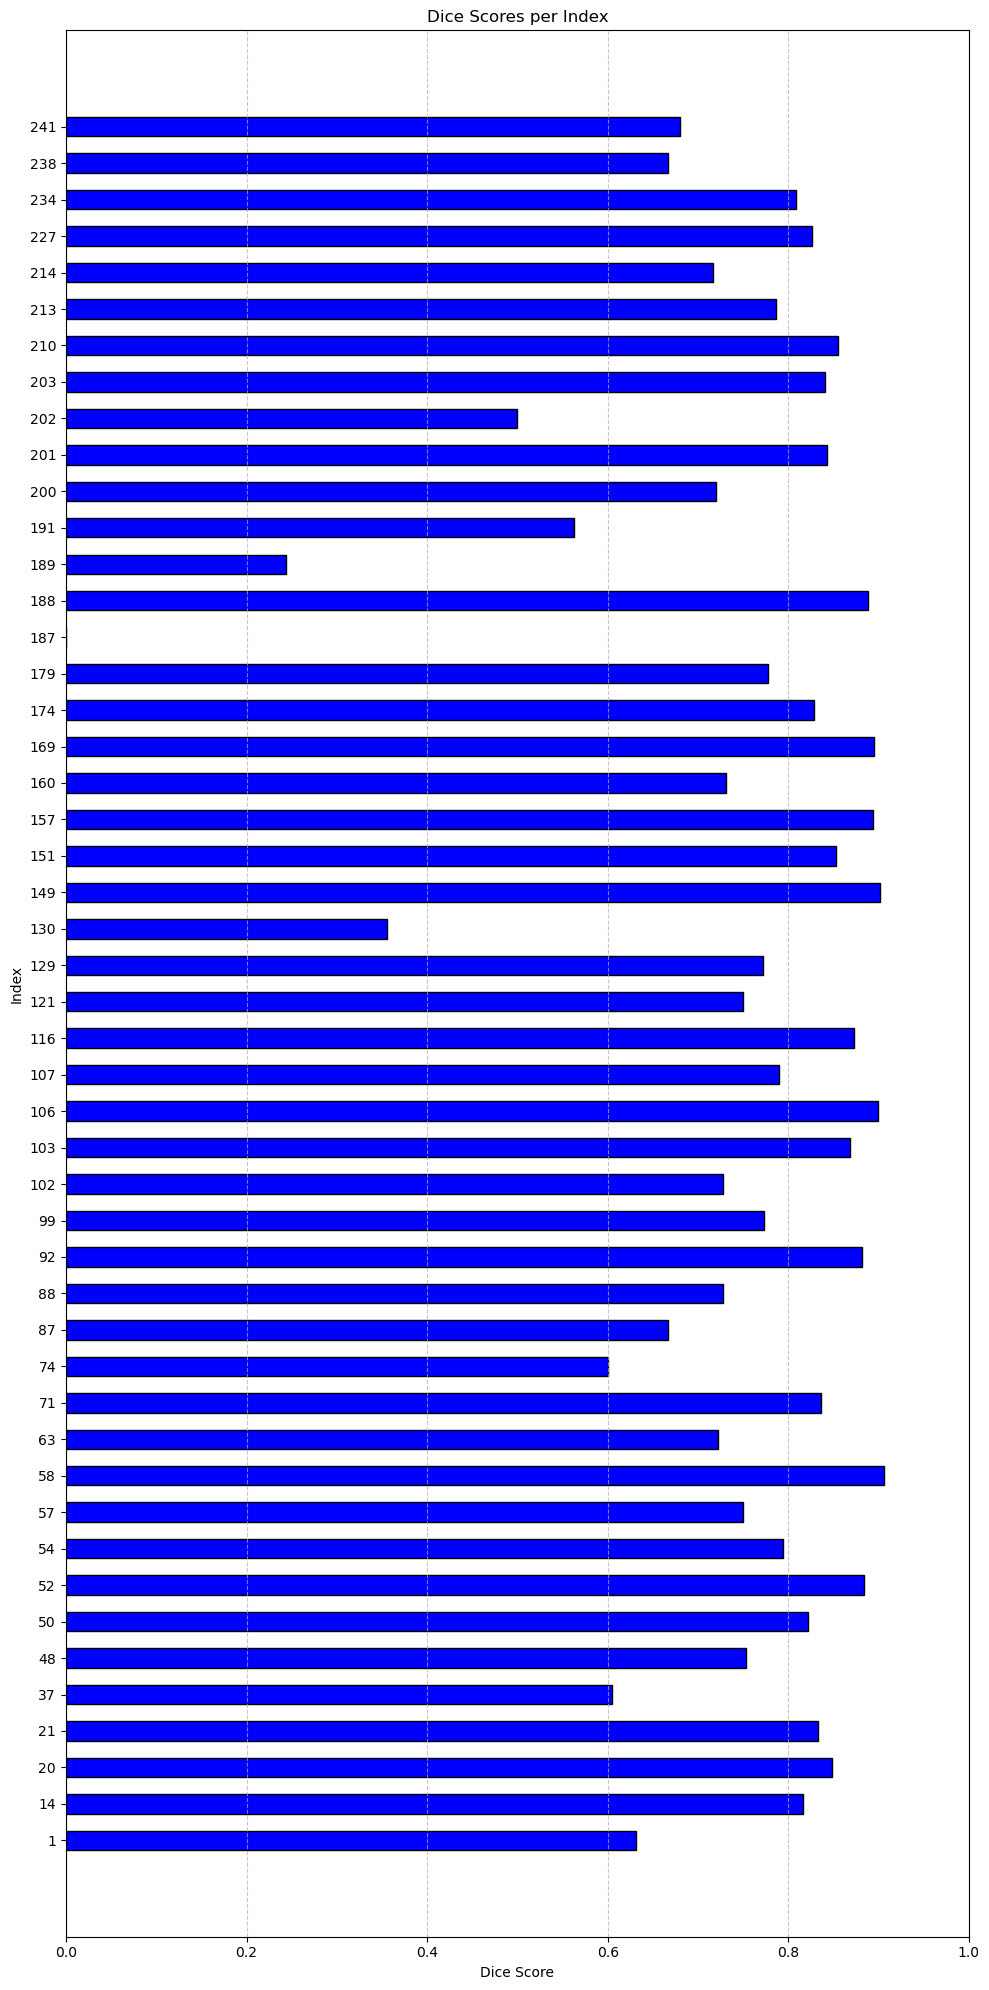

In [40]:
plotDice(dataframes[4])

In [37]:
def plot_test_image_with_contours(index, X_test, Y_test):
    """
    Plots multiple slices of a 3D test image with annotated and predicted contours in the same figure.

    Parameters:
    - index: Index of the test image to plot.
    - X_test: Array of test images.
    - Y_test: Array of annotated masks/lines.
    """

    # Extract the specified test image and its corresponding masks
    img = X_test[index]
    annotated_mask = Y_test[index]

    # Predict the mask
    predicted_mask = model.predict(np.expand_dims(X_test[index, ...], axis=0))
    predicted_mask_t = predicted_mask > 0.5
    slice_indices = [
        i for i in range(img.shape[2]) if np.sum(annotated_mask[:, :, i]) > 0
    ] # Get the slices where annotation

    num_slices = len(slice_indices)
    plt.figure(figsize=(5, 5 * num_slices))

    for i, idx in enumerate(slice_indices):
        plt.subplot(num_slices, 1, i + 1)  # Create a subplot for each slice

        # Display the test image slice
        plt.imshow(img[:, :, idx], cmap="gray")

        # Display the annotated contour (in green color) for the slice
        plt.contour(annotated_mask[:, :, idx], colors="g", linewidths=0.5)

        # Display the predicted contour (in red color) for the slice
        plt.contour(
            predicted_mask_t[0, :, :, idx, 0], colors="r", linewidths=0.5
        )

        plt.title(f"Slice {idx} with Annotated (Green) and Predicted (Red) Contours")
        plt.axis("off")

    plt.tight_layout()
    plt.show()




Plot example from the last validation fold. 

1/1 [==============================] - 0s 38ms/step


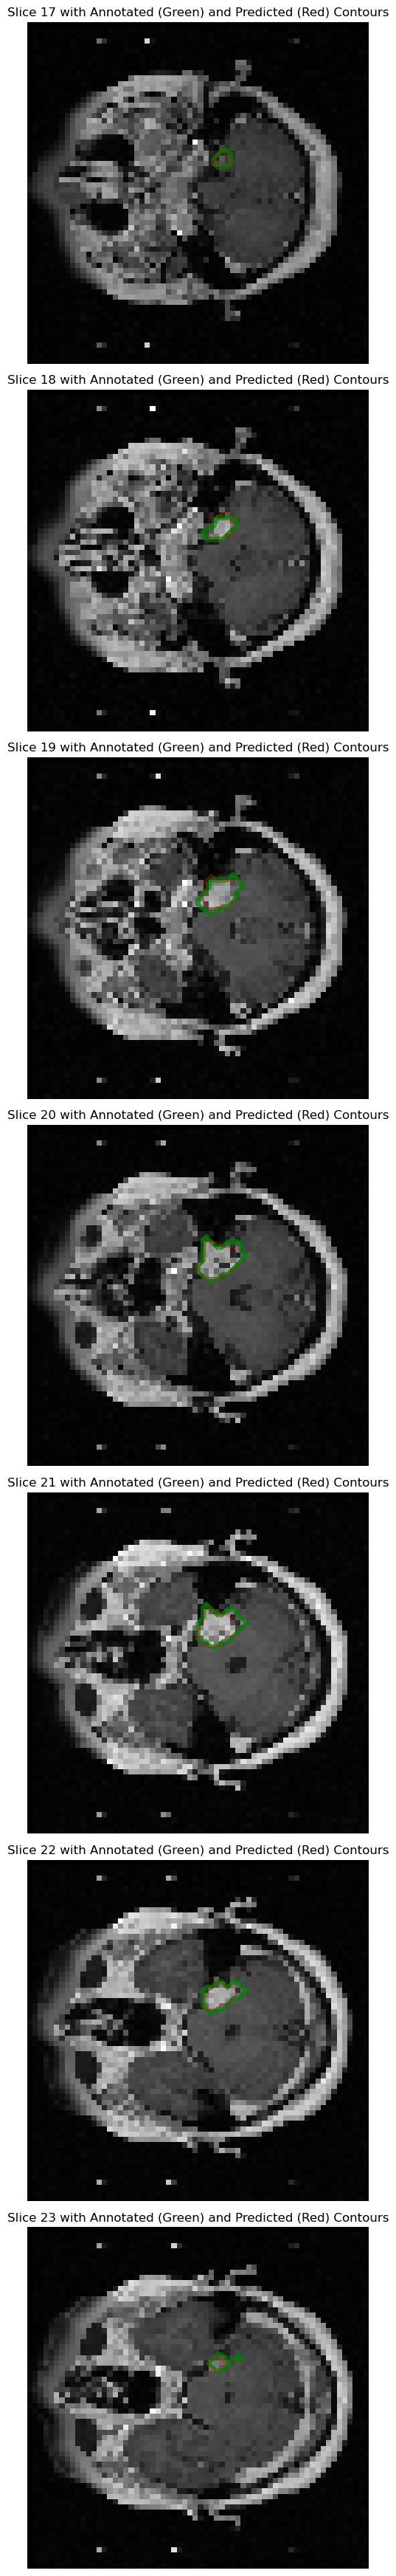

In [42]:
plot_test_image_with_contours(2, X_test, Y_test)


In [43]:
with pd.ExcelWriter(
    r"C:\Users\joona\Documents\LUT\bsc_thesis\5_fold_CV_dfs.xlsx"
) as writer:
    for i, df in enumerate(dataframes):
        df.to_excel(writer, sheet_name=f"Fold {i+1}")